In [1]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

from astropy.io import fits

from IPython.display import HTML

from hcipy import *

# from magsimpyx import make_magaox_bump_mask   # TODO: Get magsimpyx import to work


PLOT_DIR = '/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/iefc_sim_plots_perfectCG'

In [2]:
def make_magaox_bump_mask(normalized=False, with_spiders=True):
    '''Make the Magellan bump mask.

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 6.5 meters.
    with_spiders: boolean
        If this is False, the spiders will be left out.

    Returns
    -------
    Field generator
        The Magellan aperture.
    '''

    # TODO: Magnify bump mask vals. and preserve default vals

    magnification_factor = 6.5/9e-3 # Mag factor to scale 9 mm bump mask up to 6.5 m pupil diameter
    mask_inner = 2.79e-3 * magnification_factor # meter
    mask_outer = 8.604e-3 * magnification_factor # meter

    bump_mask_diameter = 0.5742e-3 * magnification_factor

    bump_mask_pos = [2.853e-3 * magnification_factor, -0.6705e-3 * magnification_factor] 

    radius = np.hypot(bump_mask_pos[0], bump_mask_pos[1])
    theta = np.arctan2(bump_mask_pos[1], bump_mask_pos[0]) - np.rad2deg(38.7747) + np.pi/2 # Adjusted bump angle to better center it on spider
    bump_mask_pos = [radius * np.cos(theta), radius * np.sin(theta)]



    pupil_diameter = 6.5 # meter
    spider_width1 = 0.1917e-3 * magnification_factor # meter 
    spider_width2 = 0.1917e-3  * magnification_factor # meter
    central_obscuration_ratio = mask_inner / mask_outer 
    spider_offset = [0, 0.34]  # meter

    if normalized:
        spider_width1 /= pupil_diameter
        spider_width2 /= pupil_diameter
        bump_mask_pos = [x / pupil_diameter for x in bump_mask_pos]
        bump_mask_diameter = (0.5742e-3 * magnification_factor) / pupil_diameter


        spider_offset = [x / pupil_diameter for x in spider_offset]
        pupil_diameter = 1.0

    spider_offset = np.array(spider_offset)

    mirror_edge1 = (pupil_diameter / (2 * np.sqrt(2)), pupil_diameter / (2 * np.sqrt(2)))
    mirror_edge2 = (-pupil_diameter / (2 * np.sqrt(2)), pupil_diameter / (2 * np.sqrt(2)))
    mirror_edge3 = (pupil_diameter / (2 * np.sqrt(2)), -pupil_diameter / (2 * np.sqrt(2)))
    mirror_edge4 = (-pupil_diameter / (2 * np.sqrt(2)), -pupil_diameter / (2 * np.sqrt(2)))

    obstructed_aperture = make_obstructed_circular_aperture(pupil_diameter, central_obscuration_ratio)
    bump_mask = make_circular_aperture(bump_mask_diameter, center=bump_mask_pos) # Generate bump cover for Magellan pupil
    
    if not with_spiders:
        return obstructed_aperture

    spider1 = make_spider(spider_offset, mirror_edge1, spider_width1)
    spider2 = make_spider(spider_offset, mirror_edge2, spider_width1)
    spider3 = make_spider(-spider_offset, mirror_edge3, spider_width2)
    spider4 = make_spider(-spider_offset, mirror_edge4, spider_width2)

    def func(grid):
        return obstructed_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid) * (1 - bump_mask(grid))
    return func

In [27]:
# Set units

magnification_factor = (9*1e-3)/6.5
pupil_diameter = 6.5
# effective_focal_length = 71.5 
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution

# Set up pupil/focal grids
mpl.rcParams['figure.dpi'] = 100


pupil_grid = make_pupil_grid(256, diameter=pupil_diameter)
focal_grid = make_focal_grid(q=4, num_airy=16, spatial_resolution = wavelength/pupil_diameter)
# Create CG focal grid to oversample CG
coro_focal_grid = make_focal_grid(q=32, num_airy=4, spatial_resolution = wavelength/pupil_diameter)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)



/tmp/ipykernel_660457/572652389.py:3: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  telescope_pupil = evaluate_supersampled(circular_aperture(pupil_diameter), pupil_grid, 4)


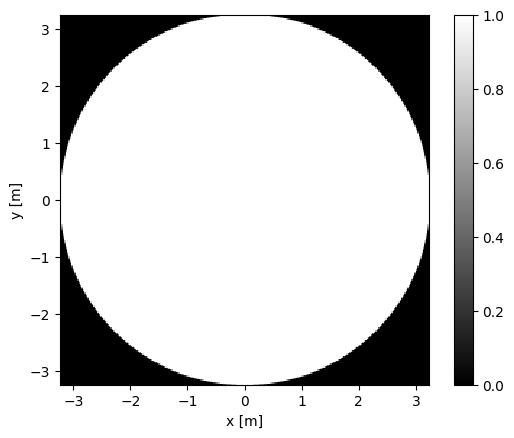

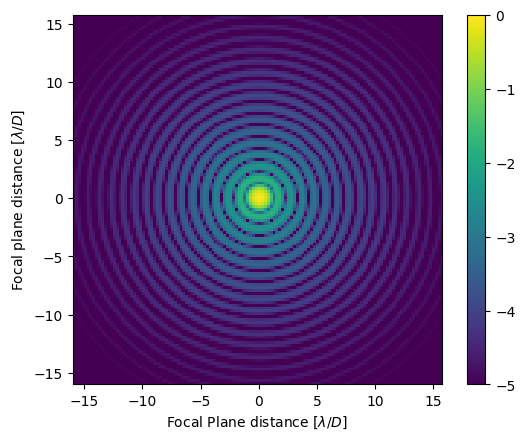

In [28]:
# Plot the bump mask scaled up to MagAO-X pupil diameter

telescope_pupil = evaluate_supersampled(circular_aperture(pupil_diameter), pupil_grid, 4)

# Plot telescope pupil
imshow_field(telescope_pupil, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

wavefront = Wavefront(telescope_pupil, wavelength)

focal_image = prop.forward(wavefront)

norm = focal_image.intensity.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()

(65536,)


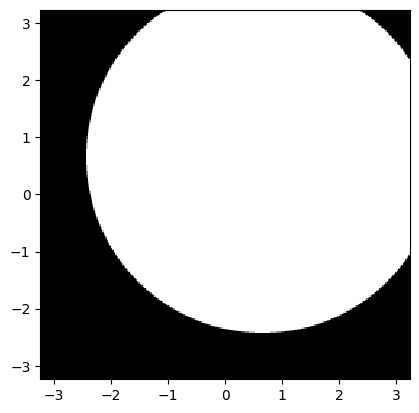

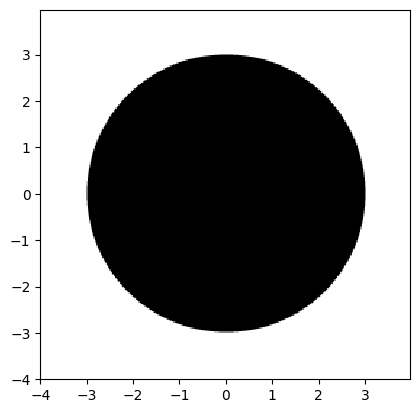

In [99]:
center_pos = np.array([0*pupil_diameter, 0]) # Pupil plane shift is defined in percentage of the pupil
# Generate slightly undersized Lyot Stop
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter, center=center_pos), pupil_grid, 4)

# Note: This should be opaque!
focal_plane_mask = 1 - evaluate_supersampled(make_circular_aperture(6*sr), coro_focal_grid, 4) # Define FPM w/ diameter of 6 lambda/D and oversampled CG grid

lyot_stop = Apodizer(lyot_mask)

imshow_field(lyot_mask, cmap='gray')

print(focal_plane_mask.shape)
plt.figure()
imshow_field(focal_plane_mask, cmap='gray', grid_units=sr)

plt.show()

In [42]:
# Generate a Lyot CG on the oversample CG grid
order = 2
coro = LyotCoronagraph(pupil_grid, focal_plane_mask, lyot_stop,  focal_plane_mask_grid=coro_focal_grid)


In [43]:
#  Construct 1k DM
num_actuators_across_pupil = 34
actuator_spacing = pupil_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing, x_tilt=np.rad2deg(45))
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

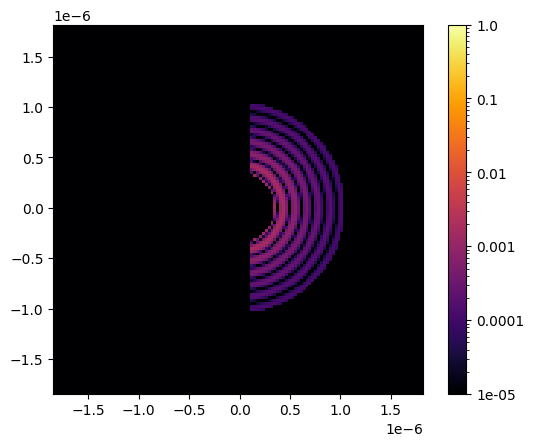

In [44]:
# Define control region
Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid

fourier_mask = (fourier_grid.as_('polar').r < 10) * (fourier_grid.as_('polar').r > 2)   # Overlay modes from 2-10 lambda/d
fourier_mask *= fourier_grid.x > 0

focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
focal_mask *= focal_grid.x > 1*sr

dark_hole_pixels = focal_image.power*focal_mask # Apply DH mask to image

imshow_psf(dark_hole_pixels/focal_image.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     

fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region

fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region

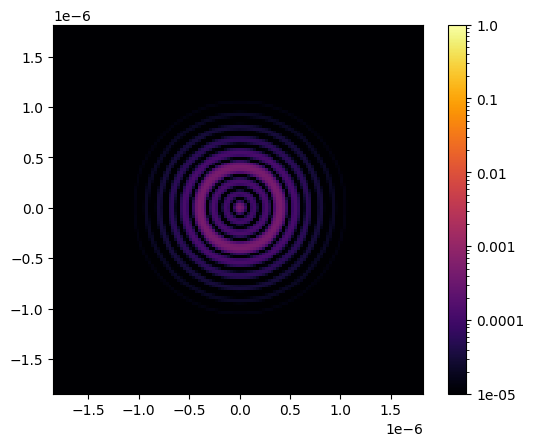

In [45]:
# Determine where actuator falls wrt pupil and define probes

fourier_dm.flatten()

probe_amp = 0.01 * wavelength

wf = Wavefront(telescope_pupil, wavelength) # Reference WF
wf.total_power = 1

norm = prop(wf).power.max() # Normalize w/ unaberrated WF

# Apply sin wave to DM
# fourier_dm.actuators[20] += probe_amp        

 # Propagate WF through system
dm_wf = fourier_dm.forward(wf) # WF after DM
lyot_wf = coro(wf) # WF in the Lyot Plane
psf = prop(lyot_wf).power

imshow_psf(psf / norm, vmax=1, vmin=1e-5)
# imshow_psf(prop(dm_wf).power / norm, vmax=1, vmin=1e-5)

plt.show()

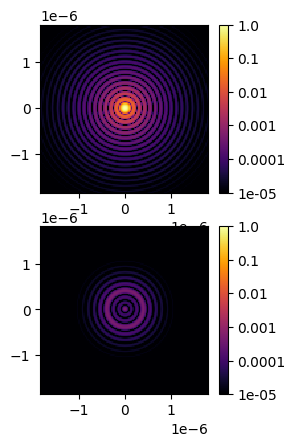

In [46]:
psf = prop(wf).power # prop = lense

norm = psf.max()

corim = prop(coro(wf)).power # prop = lense

plt.subplot(2,2,1)
imshow_psf(psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale

plt.subplot(2,2,3)
imshow_psf(corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale

plt.show()

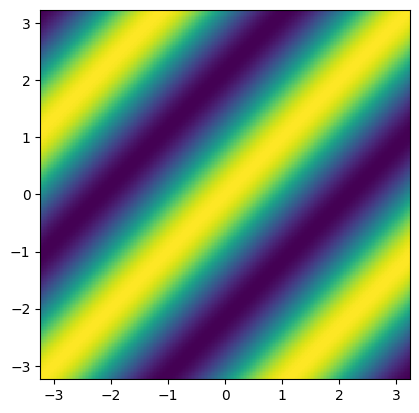

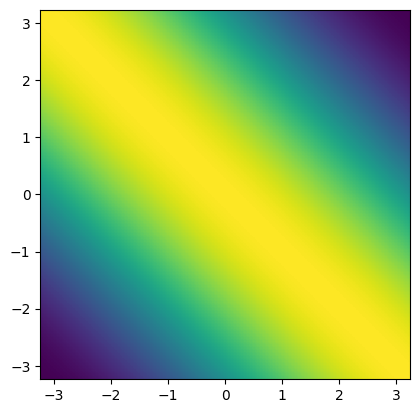

In [47]:
# View probe in the DM plane

fourier_dm_selected.flatten()

fourier_dm_selected.actuators[0] = 1.0
imshow_field(fourier_dm_selected.surface)
plt.show()


fourier_dm.flatten()

fourier_dm.actuators[0] = 1.0
imshow_field(fourier_dm.surface)
plt.show()

In [48]:
# Generate a sequence of pairwise probe, difference images
def make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=EmptyOpticalElement()):
    
    # Generate a 'perform_pwp' function that can be evaluated for a given WF
    def func(wavefront):
        dm.flatten()

        difference_images = []
        for probe_pattern in [probe_1, probe_2]:
            # Apply +/- probe 1
            probed_psfs = []
            for amp in [-probe_amp, probe_amp]:

                dm.actuators[probe_pattern] += amp # Apply +/- probe 1 
                # Propagate WF through system
                dm_wf = dm.forward(wavefront) # WF after DM
                psf = optical_system(dm_wf).power
                probed_psfs.append(psf)
                dm.actuators[probe_pattern] -= amp

            # Compute difference image 1
            diff_image = probed_psfs[1] - probed_psfs[0]
            difference_images.append(diff_image)

        return difference_images

    return func

# Create function which will obtain measurements from PWP images
def extract_measurement_from_difference_images(difference_images, dark_hole_mask=dark_hole_pixels, number_of_probes=2):
    difference_dark_hole_pixels = [difference_images[i][dark_hole_mask] for i in range(number_of_probes)]   # Make list of diff DH images
    pwp_measurement = np.concatenate(difference_dark_hole_pixels)   # Combine into a list
    return pwp_measurement

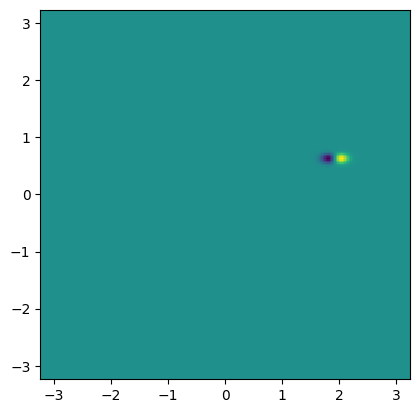

In [49]:
# Plot locations of pairwise probes on DM surface
deformable_mirror.flatten()
deformable_mirror.actuators[400] = 1
deformable_mirror.actuators[401] = -1
imshow_field(deformable_mirror.surface)
plt.show()
deformable_mirror.flatten()

In [50]:
optical_system = OpticalSystem([coro, prop,])
pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)

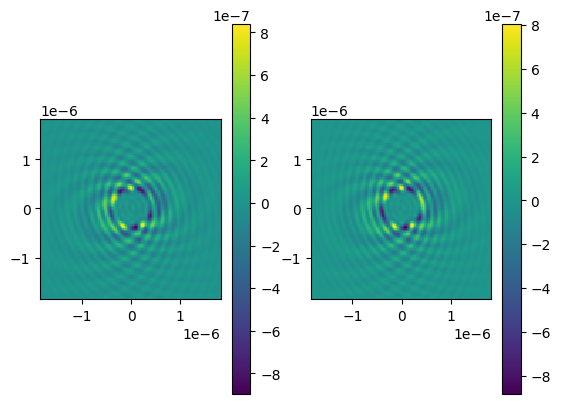

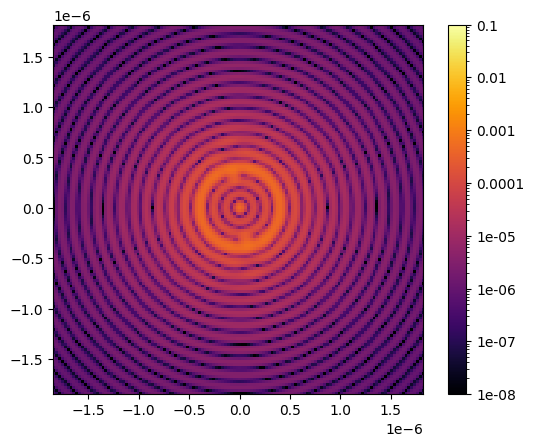

In [51]:
fourier_dm_selected.flatten()
fourier_dm_selected.actuators[10] = 0.01 * wavelength

response = pwp_sensor(fourier_dm_selected(wf))
plt.subplot(1,2,1)
imshow_field(response[0], focal_grid)
plt.colorbar()
plt.subplot(1,2,2)
imshow_field(response[1], focal_grid)
plt.colorbar()
plt.show()

# Plot PSF after applying probes
wfout = optical_system(fourier_dm_selected(wf))
plt.figure()
imshow_psf(wfout.power/norm)
plt.show()

fourier_dm_selected.flatten()

In [52]:

# # Jacobian (iEFC)

######## NEW GITHUB VERSION ##########################



response_matrix_selected = [] # Initialize empty vector of slopes

probe_amp = 0.01 * wavelength # Set a probe amplitude
calibration_amp = 0.01 * wavelength

wf = Wavefront(telescope_pupil, wavelength) # Reference WF
wf.total_power = 1

norm = prop(wf).power.max() # Normalize w/ unaberrated WF

num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region

amps = np.ones(num_modes) * probe_amp

deformable_mirror.flatten()
fourier_dm_selected.flatten()

for ind in range(num_modes):
    if ind % 10 == 0:
        print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
    
    calibration_images = []
    for cal_amp in [-calibration_amp, calibration_amp]:

        # Add the mode that we are calibrating
        fourier_dm_selected.actuators[ind] += cal_amp #  (Fourier DM) Ensure that we are only calibrating modes that fall on the pupil

        diff_images = pwp_sensor(fourier_dm_selected(wf))  # Perform PWP

        pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels>0) # Extract diff image measurements for DH region
        
        calibration_images.append(pwp_measurement)

        # Remove the mode that we are calibrating
        fourier_dm_selected.actuators[ind] -= cal_amp

    slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

    response_matrix_selected.append(slope) # Append slope vector to response matrix

response_matrix_selected = np.array(response_matrix_selected)

    #################################### JACOBIAN PSEUDOCODE IEFC ##################################################
# Initialize empty vector of slopes (response matrix)
# For each mode
#   For amplitude in [-amp, amp]
    #   Apply mode on DM w/ a given amplitude

    #   Apply + probe 1
    #   Propagate WF through system
    #   Take intensity image (PSF)
    #   Apply - probe 1
    #   Propagate WF through system
    #   Take intensity image
    #   Compute difference image 1

    #   Apply + probe 2
    #   Propagate WF through system
    #   Take intensity image
    #   Apply - probe 2
    #   Propagate WF through system
    #   Take intensity image
    #   Compute difference image 2

    #   Pair-wise probing sensing signal = [diff 1, diff_2]
    #   Concatenate intensity differences
    #   Construct slope vector -- amplitude * [(diff 1 - diff 2)/(2*amp)]
#   Append slope vector to response matrix

Measure response to mode 1 / 304
Measure response to mode 11 / 304
Measure response to mode 21 / 304
Measure response to mode 31 / 304
Measure response to mode 41 / 304
Measure response to mode 51 / 304
Measure response to mode 61 / 304
Measure response to mode 71 / 304
Measure response to mode 81 / 304
Measure response to mode 91 / 304
Measure response to mode 101 / 304
Measure response to mode 111 / 304
Measure response to mode 121 / 304
Measure response to mode 131 / 304
Measure response to mode 141 / 304
Measure response to mode 151 / 304
Measure response to mode 161 / 304
Measure response to mode 171 / 304
Measure response to mode 181 / 304
Measure response to mode 191 / 304
Measure response to mode 201 / 304
Measure response to mode 211 / 304
Measure response to mode 221 / 304
Measure response to mode 231 / 304
Measure response to mode 241 / 304
Measure response to mode 251 / 304
Measure response to mode 261 / 304
Measure response to mode 271 / 304
Measure response to mode 281 / 

In [53]:
# Compute reconstruction matrix
rcond = 2e-3
reconstruction_matrix_selected = inverse_tikhonov(response_matrix_selected.T, rcond=rcond, svd=None) # Feed in response matrix for DH modes

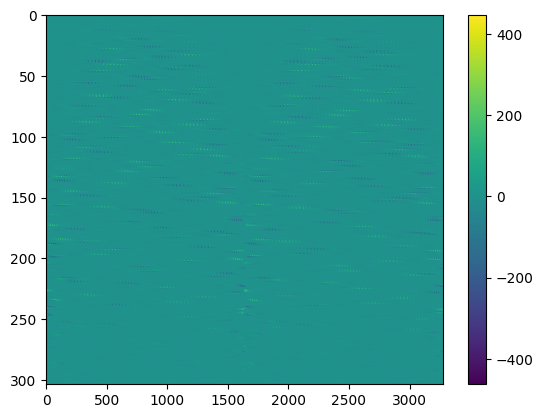

In [54]:
# Plot slopes from response matrix
plt.imshow(response_matrix_selected,aspect='auto')
plt.colorbar()
plt.show()

In [55]:
# Double check Jacobian dims

print(reconstruction_matrix_selected.shape) # Jacobian going from modes to pixels

print(response_matrix_selected.T.shape) # Jacobian transforming from pixels to modes

(304, 3276)
(3276, 304)


In [122]:
### PID - controller
# Proportional - Integral - Differential controller
# e = (Y - U)
# U = p * e + k * integral e(t) dt + g * d/dt e(t)
# U = k * integral e(t)

# Integral controller <-> Integrator
# U_i+1 = U_i + gain * e(t_i)
# system is only stable for gains < gain_max

def run_iefc(tip_tilt=0, lyot_offset=0, num_iterations=20, efc_gain=0.5, aberrations=0.1, sa=None):

    fourier_dm_selected.flatten()

    deformable_mirror.flatten()

    # Offset Lyot stop position along x
    lyot_offset = np.array([lyot_offset*pupil_diameter, 0]) 
    lyot_mask_imperfect = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter, center=lyot_offset), pupil_grid, 4)

    lyot_stop_imperfect = Apodizer(lyot_mask)

    coro_imperfect = LyotCoronagraph(pupil_grid, focal_plane_mask, lyot_stop_imperfect,  focal_plane_mask_grid=coro_focal_grid)

    TT = TipTiltMirror(pupil_grid)
    TT.flatten()
    TT.actuators[0] = tip_tilt/5 * sr / 2  # Divide offset by 5 b/c we have 5 pix/lam0D
    # print(TT.actuators[0])
    imperfect_optical_system = OpticalSystem([coro_imperfect, TT, prop,]) # Propagate through imperfect optical system
    imperfect_pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=imperfect_optical_system)

    if sa is None:
        zmodes = make_zernike_basis(3, Dtel, pupil_grid)
        sa = SurfaceAberration(pupil_grid, aberrations * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil, remove_modes=zmodes)   # Apply 1/10 lambda of surface aberration
    # num_iterations = 20

    actuator_cmds = np.zeros(fourier_dm_selected.num_actuators)

    # efc_gain = 0.5

    current_cmds = []
    image_cube = []

    mean_ni = []

    image_cube.append(imperfect_optical_system(fourier_dm_selected(sa(wf))).power / norm)
    for i in range(num_iterations):

        wf_output = fourier_dm_selected(sa(wf))

        
        diff_images = imperfect_pwp_sensor(wf_output)  # Perform PWP

        pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels>0) # Extract diff images
        
        # current_cmds = np.append(actuator_cmds.copy())

        ef_error = reconstruction_matrix_selected.dot(pwp_measurement) # Transform WF sensing measurement into DM pattern that gives us error
        actuator_cmds -= efc_gain*ef_error # Apply opposite phase to DM so as to cancel E-field

        fourier_dm_selected.actuators = actuator_cmds # Send the dm_i+1 command(?)

        image_cube.append(imperfect_optical_system(fourier_dm_selected(sa(wf))).power / norm)

    mean_ni = [np.mean(image[dark_hole_pixels>0]) for image in image_cube]

    image_cube = np.array(image_cube)

    # fits.writeto() # Save image cube

    # Uncomment if saving the individual images
    # image_cube_field = Field(image_cube, focal_grid)  
    # write_field(image_cube_field, f'/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/Lyot_shift/Images/cube_ls{lyot_offset}.fits')

    return image_cube, mean_ni  # TT.actuators



# mean_ni = [image_cube[]]
    # E-field error = 
    


##### Pseudo code
    # For each iteration
        # Sense the WF
            # Do pairwise probing (turn above code into a function)--returns difference images
            # Mask difference images
        # Process the WF into a command
            # EF error = dot double diff imgs w/ inverted Jacobian
            # Use integrator -> dm_i+1 = dm_i - gain * EF error
        # Send the command
        # send the dm_i+1 command to the dm




# image_cube_sel = image_cube[0][dark_hole_pixels>0]

# imshow_psf(image_cube[0], vmax=1, vmin=1e-7)




In [123]:
zmodes = make_zernike_basis(3, Dtel, pupil_grid)
sa = SurfaceAberration(pupil_grid, 0.1 * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil, remove_modes=zmodes)   # Apply 1/10 lambda of surface aberration

/home/jasper/hcipy/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [124]:
x = np.linspace(0, 0.05, 11)
print(x.shape)

y = np.zeros(x.shape)
print(y.shape)

tot = np.array(np.meshgrid(x,y))
# tot[0][2]
tot.shape

(11,)
(11,)


(2, 11, 11)

In [126]:
# Shift Lyot stop along x by percentages of pupil diameter
lyot_shifts = np.linspace(0, 0.05, 11)
# lyot_shifts_y = np.zeros(lyot_shifts_x.shape)
# lyot_shifts = np.meshgrid(lyot_shifts_x, lyot_shifts_y)
image_cubes = []
means = []
for i, lyot_shift in enumerate(lyot_shifts):
    print(i, lyot_shifts)
    img_cube_0, mean_ni_0, = run_iefc(lyot_offset=lyot_shift, num_iterations=40, efc_gain=0.4, sa=sa) # Freeze sa such that soln. stays the same every time
    image_cubes.append(img_cube_0)
    means.append(mean_ni_0)

#img_cube_0, mean_ni_0, = run_iefc(tip_tilt=0, sa=sa)
#img_cube_1, mean_ni_1, = run_iefc(tip_tilt=0.25)
#img_cube_2, mean_ni_2 = run_iefc(tip_tilt=0.5)
#img_cube_3, mean_ni_3 = run_iefc(tip_tilt=0.75)      # Question for Sebastiaan: Why are calculated NI values changing when I re-run the iEFC controller? Shouldn't they be the same each time in simulation?
#img_cube_4, mean_ni_4 = run_iefc(tip_tilt=1) 
#img_cube_5, mean_ni_5 = run_iefc(tip_tilt=1.25) 
#img_cube_6, mean_ni_6 = run_iefc(tip_tilt=1.50) 
#img_cube_7, mean_ni_7 = run_iefc(tip_tilt=1.75) 
#img_cube_8, mean_ni_8 = run_iefc(tip_tilt=2) 




0 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
1 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
2 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
3 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
4 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
5 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
6 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
7 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
8 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
9 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]
10 [0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05 ]


In [128]:
means = np.array(means)

means[1][-1]

8.832212306985894e-05

In [97]:
means[1]

array([7.23861619e-05, 2.96006657e-05, 1.67948240e-05, 1.65353838e-05,
       2.35214879e-05, 3.83721170e-05, 6.52118269e-05, 1.13258359e-04,
       1.99705123e-04, 3.44618075e-04, 5.21444861e-04, 6.04574949e-04,
       5.64173717e-04, 4.97652776e-04, 4.48552210e-04, 4.23691757e-04,
       4.17237500e-04, 4.18230514e-04, 4.26574163e-04, 4.22699038e-04,
       3.95341161e-04, 3.60782439e-04, 3.20390237e-04, 2.77493800e-04,
       2.53349295e-04, 2.55878226e-04, 2.77989595e-04, 3.19529371e-04,
       3.90500089e-04, 4.96457152e-04, 6.17978028e-04, 7.12020219e-04,
       7.80200263e-04, 8.17012090e-04, 7.56705767e-04, 6.37759909e-04,
       5.31381480e-04, 4.49202344e-04, 3.89783641e-04, 3.44938769e-04,
       3.09185825e-04])

In [74]:
final_means = [i[-1] for i in means]


In [75]:
final_means

[Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457),
 Field(0.00019457)]

In [31]:
means = np.array(means)
# print(means.shape)

# means.T

array([[4.74725662e-05, 4.87620794e-05, 5.00005509e-05, 5.11619914e-05,
        5.22414746e-05, 5.32602858e-05, 5.42672272e-05, 5.53358048e-05,
        5.65576743e-05, 5.80332183e-05, 5.98604115e-05],
       [1.75491358e-05, 1.82518897e-05, 2.09221780e-05, 2.53299100e-05,
        3.09252490e-05, 3.70369234e-05, 4.31443795e-05, 4.90335380e-05,
        5.47284254e-05, 6.02732072e-05, 6.55538157e-05],
       [6.31348857e-06, 6.69259119e-06, 9.00888514e-06, 1.43359529e-05,
        2.34286369e-05, 3.56613673e-05, 4.94549092e-05, 6.37818454e-05,
        7.82886033e-05, 9.22168662e-05, 1.04338696e-04],
       [2.25661286e-06, 2.43958838e-06, 4.04048259e-06, 9.27198439e-06,
        2.17572708e-05, 4.29128214e-05, 6.91850708e-05, 9.78941533e-05,
        1.29346718e-04, 1.60119480e-04, 1.85040852e-04],
       [8.20693314e-07, 9.02536557e-07, 1.91242533e-06, 6.69679874e-06,
        2.31131702e-05, 5.93654427e-05, 1.07965550e-04, 1.59638930e-04,
        2.19188713e-04, 2.81294229e-04, 3.28679350e-

In [49]:
means


array([[5.36695075e-05, 1.96206016e-05, 7.08002871e-06, 2.56273213e-06,
        9.48560701e-07, 3.72650689e-07, 1.66990558e-07, 9.34553199e-08,
        6.71678795e-08, 5.78183501e-08, 5.45532176e-08, 5.34737727e-08,
        5.31753867e-08, 5.31512006e-08, 5.32187896e-08, 5.33133469e-08,
        5.34127135e-08, 5.35100720e-08, 5.36039702e-08, 5.36946870e-08,
        5.37829311e-08, 5.38694013e-08, 5.39546607e-08, 5.40391229e-08,
        5.41230728e-08, 5.42066953e-08, 5.42901020e-08, 5.43733531e-08,
        5.44564742e-08, 5.45394688e-08, 5.46223278e-08, 5.47050359e-08,
        5.47875757e-08, 5.48699312e-08, 5.49520893e-08, 5.50340410e-08,
        5.51157818e-08, 5.51973121e-08, 5.52786366e-08, 5.53597647e-08,
        5.54407094e-08],
       [5.57752311e-05, 2.07189925e-05, 7.78143364e-06, 2.95525385e-06,
        1.13815964e-06, 4.52484992e-07, 1.94882363e-07, 9.89923945e-08,
        6.37345210e-08, 5.09441089e-08, 4.63591529e-08, 4.47259842e-08,
        4.41434982e-08, 4.39374523e-08,

In [67]:
means[0]

# np.arange(41).shape

array([5.36695075e-05, 1.96206016e-05, 7.08002871e-06, 2.56273213e-06,
       9.48560701e-07, 3.72650689e-07, 1.66990558e-07, 9.34553199e-08,
       6.71678795e-08, 5.78183501e-08, 5.45532176e-08, 5.34737727e-08,
       5.31753867e-08, 5.31512006e-08, 5.32187896e-08, 5.33133469e-08,
       5.34127135e-08, 5.35100720e-08, 5.36039702e-08, 5.36946870e-08,
       5.37829311e-08, 5.38694013e-08, 5.39546607e-08, 5.40391229e-08,
       5.41230728e-08, 5.42066953e-08, 5.42901020e-08, 5.43733531e-08,
       5.44564742e-08, 5.45394688e-08, 5.46223278e-08, 5.47050359e-08,
       5.47875757e-08, 5.48699312e-08, 5.49520893e-08, 5.50340410e-08,
       5.51157818e-08, 5.51973121e-08, 5.52786366e-08, 5.53597647e-08,
       5.54407094e-08])

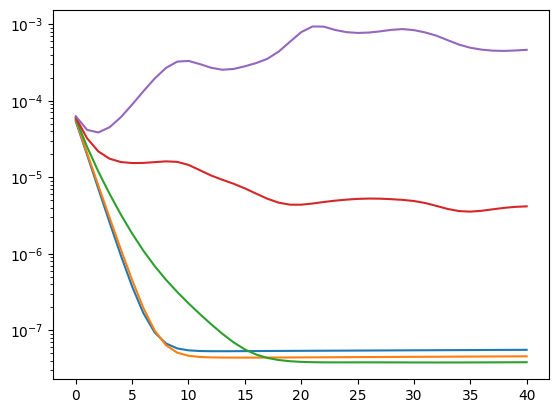

In [68]:
plt.plot(np.arange(41), means[0:5].T)
plt.yscale('log')
plt.show()

In [74]:
lam0_dshifts[2]

0.2

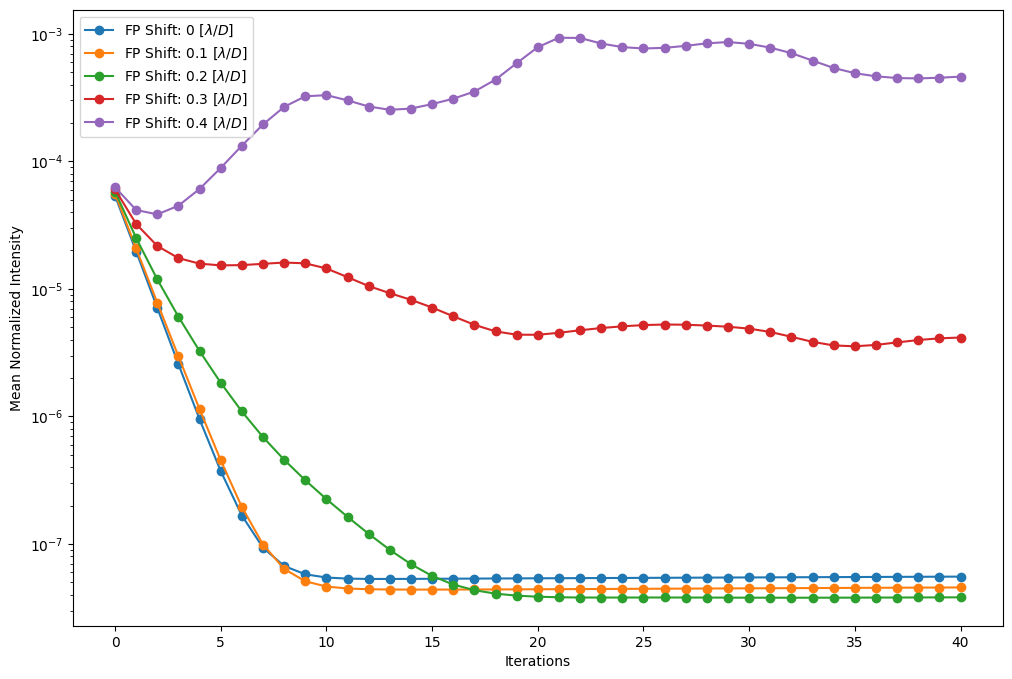

In [82]:

# fig = plt.figure(figsize=(16,9))

fig, ax = plt.subplots(1, figsize=(12,8))

ax.plot(np.arange(41), means[0:5].T, '-o')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Normalized Intensity')
# ax.set_title('iEFC Contrast')
ax.set_yscale('log')
ax.legend(['FP Shift: 0 [$\lambda / D$]', 'FP Shift: 0.1 [$\lambda / D$]', 'FP Shift: 0.2 [$\lambda / D$]', 'FP Shift: 0.3 [$\lambda / D$]', 'FP Shift: 0.4 [$\lambda / D$]', 'FP Shift: 0.5 [$\lambda / D$]'], loc='upper left')

plt.savefig(f'{PLOT_DIR}/fpshifts.png')

plt.show()


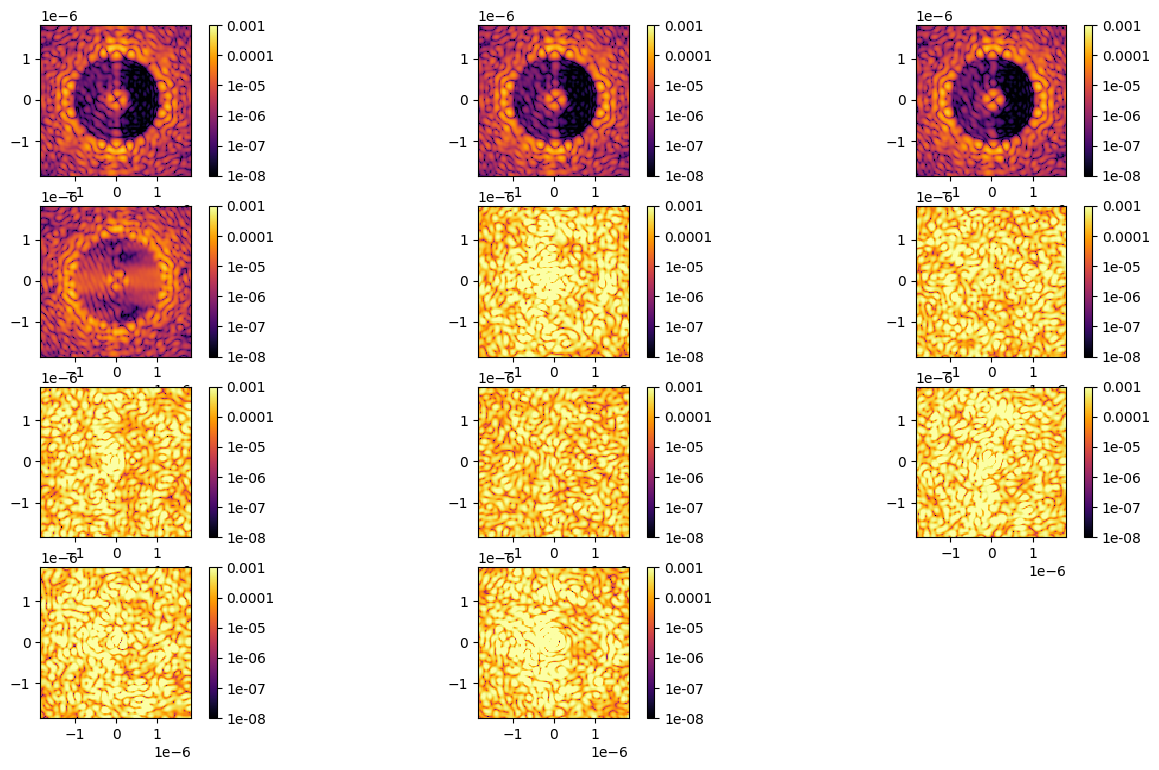

In [79]:
plt.figure(figsize=(16,9))
for i in range(11):
    plt.subplot(4,3,i+1)
    imshow_psf(image_cubes[i][-1], vmax=1e-3, vmin=1e-8)
plt.show()

In [156]:
pixel_shift = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]   # Go out to pix shift of 5 pix

final_ni = [float(mean_ni_0[-1]), float(mean_ni_1[-1]), float(mean_ni_2[-1]), float(mean_ni_3[-1]), float(mean_ni_4[-1]), float(mean_ni_5[-1]), float(mean_ni_6[-1]), float(mean_ni_7[-1]), float(mean_ni_8[-1])]

In [157]:
final_ni

[6.976464760080138e-06,
 4.561725763234546e-06,
 4.666664165618923e-06,
 3.375260292441119e-06,
 6.670219191475274e-06,
 1.3446653838818543e-05,
 2.3350586544532926e-05,
 5.814783046990178e-05,
 0.0004273293214978473]

In [149]:
final_ni

[4.502471311096786e-06,
 1.174709786703269e-05,
 4.027712870592247e-06,
 6.72519770786012e-06,
 1.468125981272993e-05,
 6.75945573262835e-06,
 1.2139170793697978e-05,
 0.00020413482212592324,
 0.0001923095857664915]

In [144]:
final_ni

[6.736441250595357e-06,
 5.174863840296531e-06,
 9.3951737502522e-06,
 5.31021892800425e-06,
 6.096756001049019e-06,
 1.1328243373010263e-05,
 3.5348770687992666e-05]

In [99]:
def write_gif(cube=img_cube_0, tip_tilt=0):
    writer = FFMpegWriter(f'./{str(cube)}_TT_{str(tip_tilt)}.mp4', framerate=4)
    for im in cube:
        fig = plt.figure(10)
        imshow_psf(im, vmax=1e-2, vmin=1e-7)
        plt.draw()
        plt.pause(0.01)
        writer.add_frame(fig)

        plt.close(10)

    writer.close()

    return writer

In [101]:
# write_gif(cube=img_cube_3, tip_tilt=0.75)

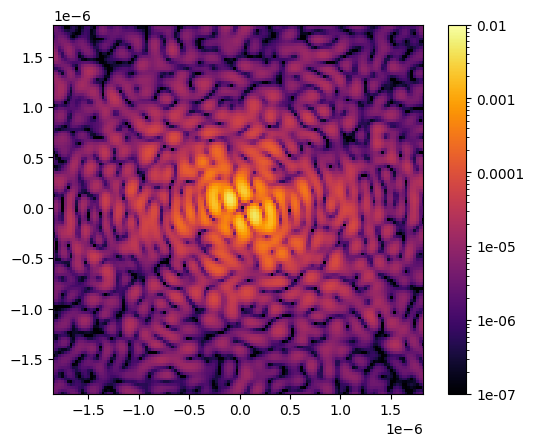

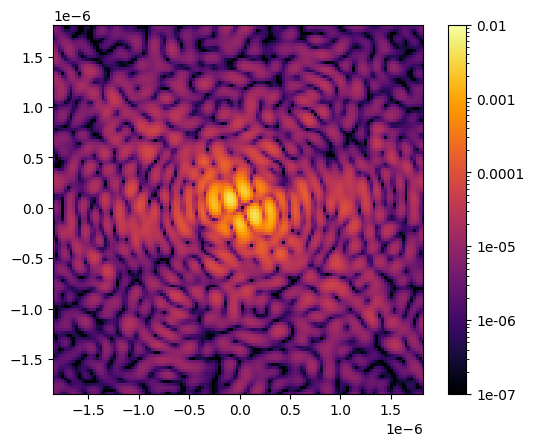

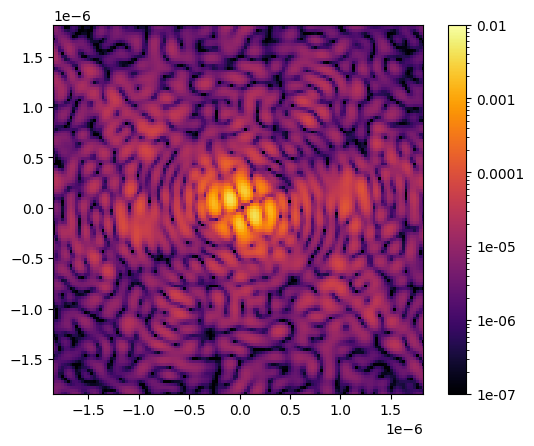

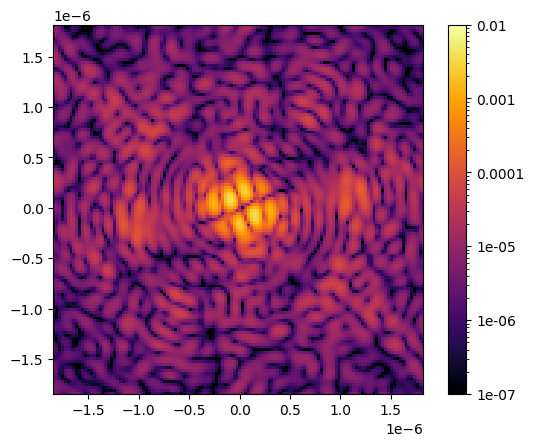

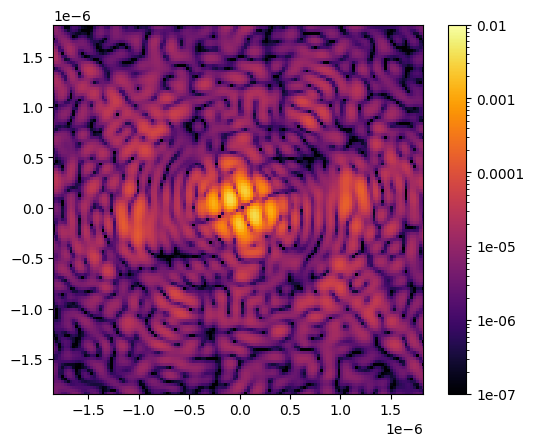

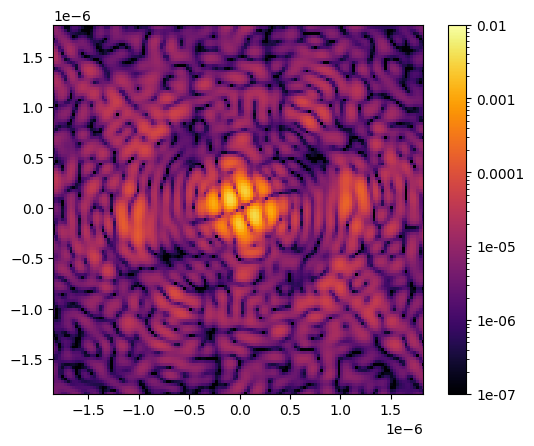

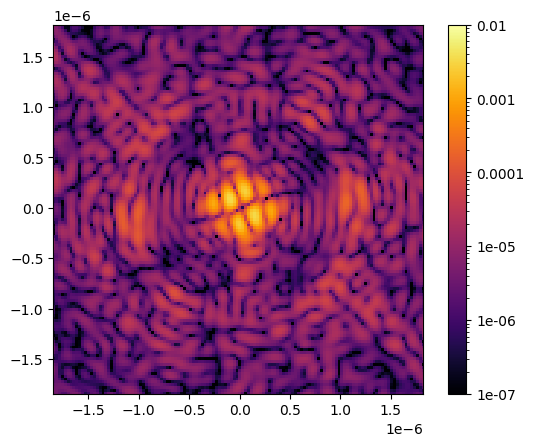

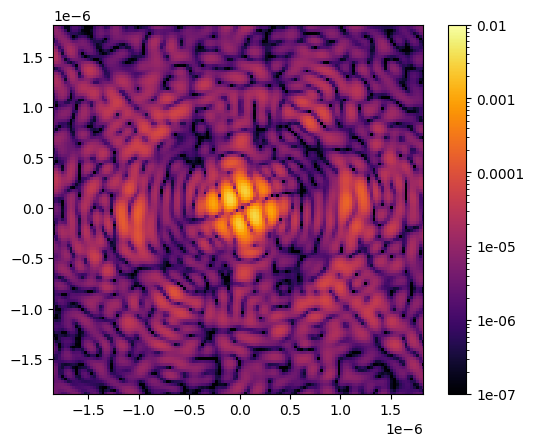

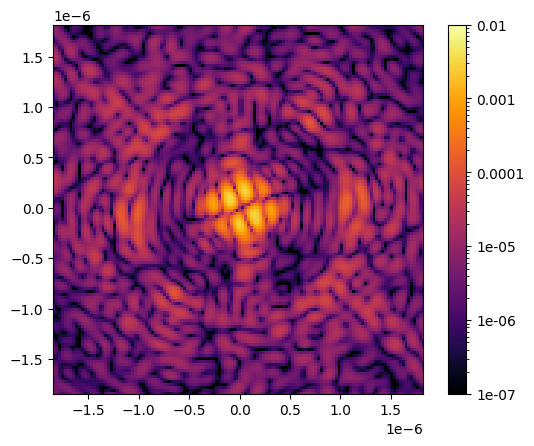

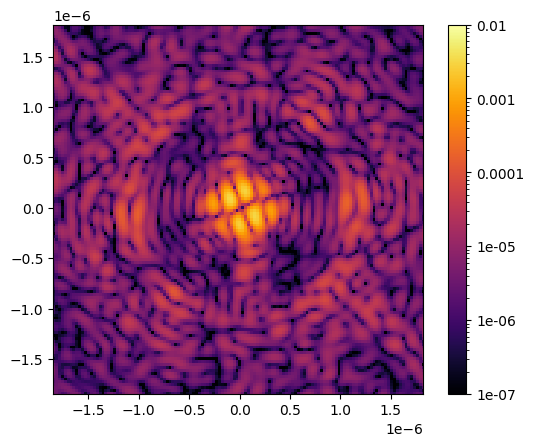

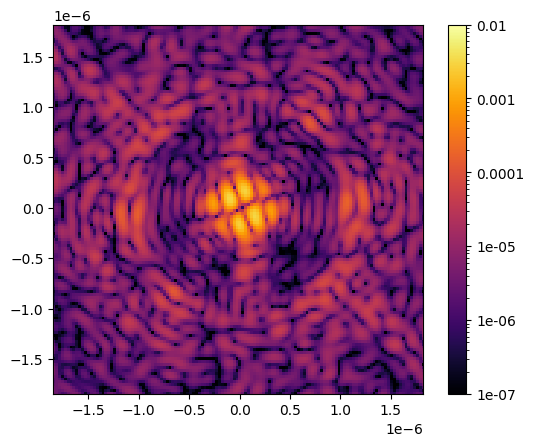

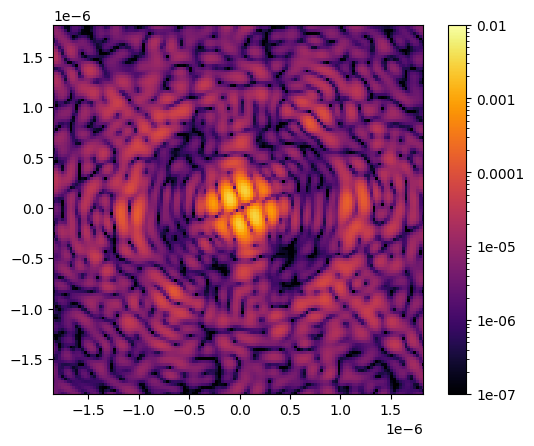

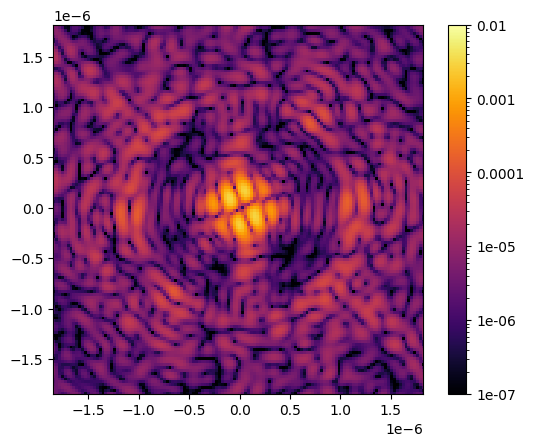

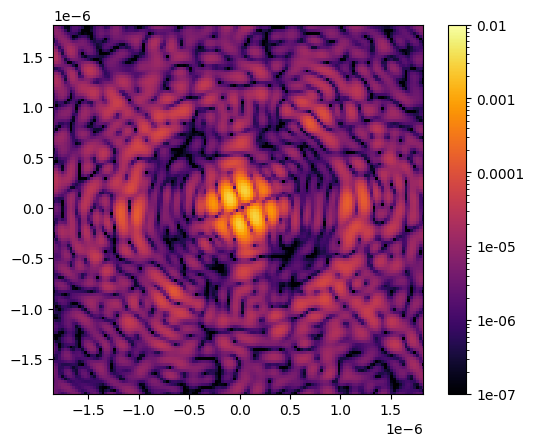

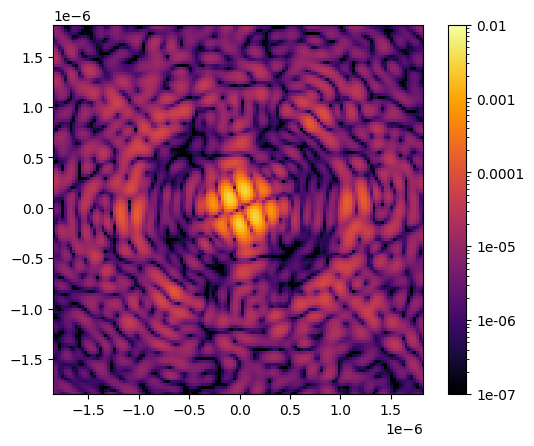

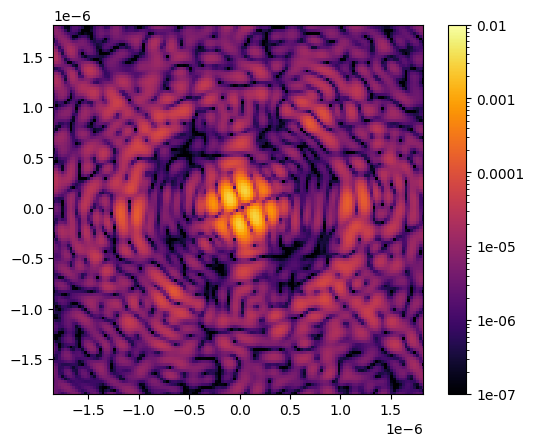

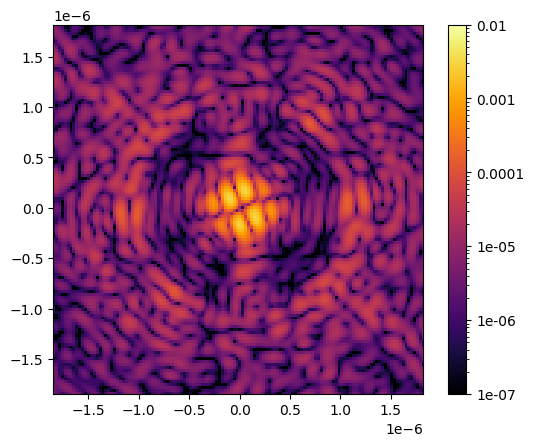

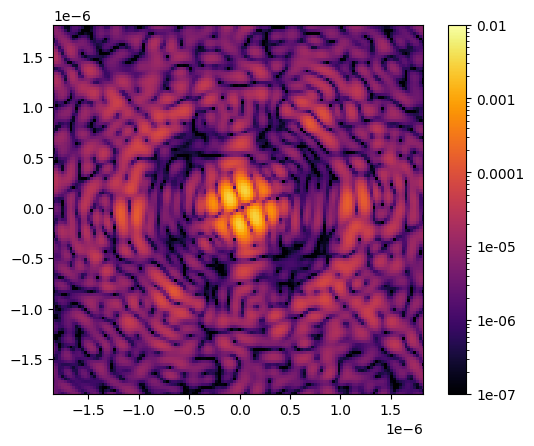

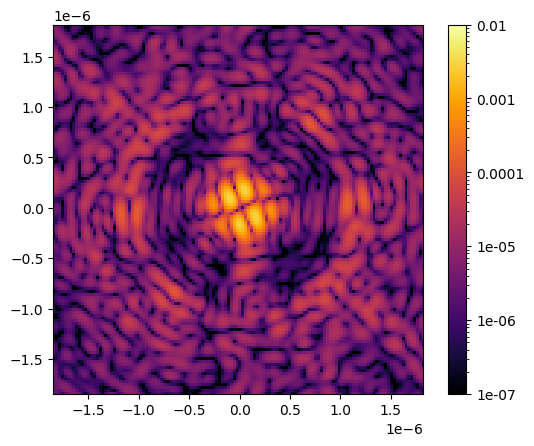

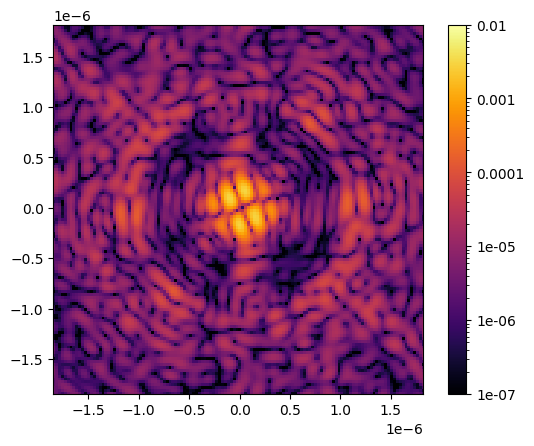

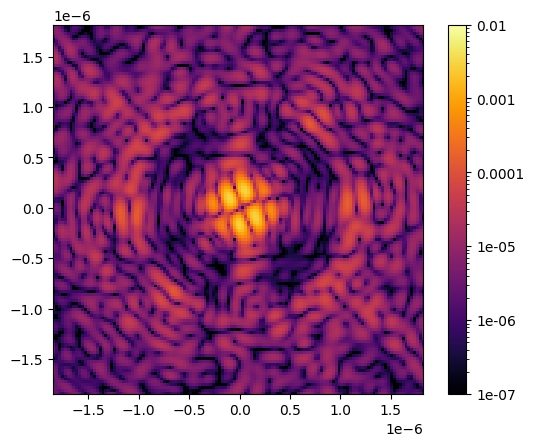

In [158]:
writer = FFMpegWriter(f'./test_TT_1.mp4', framerate=4)
for im in img_cube_4:
    fig = plt.figure(10)
    imshow_psf(im, vmax=1e-2, vmin=1e-7)
    plt.draw()
    plt.pause(0.01)
    writer.add_frame(fig)

    plt.close(10)

writer.close()

In [30]:
pixel_shift = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]

final_ni = [float(mean_ni_0[-1]), float(mean_ni_1[-1]), float(mean_ni_2[-1]), float(mean_ni_3[-1]), float(mean_ni_4[-1]), float(mean_ni_5[-1]), float(mean_ni_6[-1])]

In [31]:
final_ni

[3.9575165051967665e-06,
 7.051060837208467e-06,
 5.589437985011867e-06,
 7.220000651391651e-06,
 3.988087856799894e-06,
 1.152521869264554e-05,
 6.0814151349133835e-06]

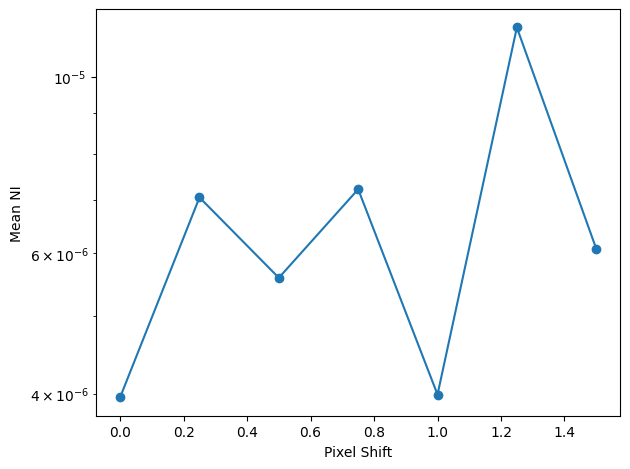

In [33]:
# Plot pixel shift against mean NI for final iteration

fig, ax = plt.subplots(1)

ax.semilogy(pixel_shift, final_ni, '-o')
ax.set_xlabel('Pixel Shift')
ax.set_ylabel('Mean NI')
ax.invert_yaxis

fig.tight_layout()

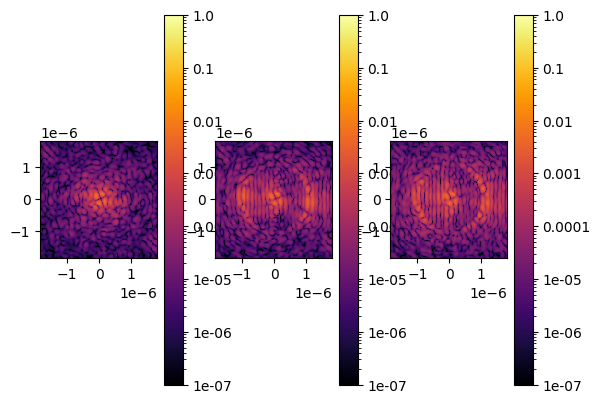

In [225]:
plt.subplot(1,3,1)
imshow_psf(image_cube[0], vmax=1, vmin=1e-7)
plt.subplot(1,3,2)
imshow_psf(image_cube[10], vmax=1, vmin=1e-7)
plt.subplot(1,3,3)
imshow_psf(image_cube[-1], vmax=1, vmin=1e-7)
plt.show()

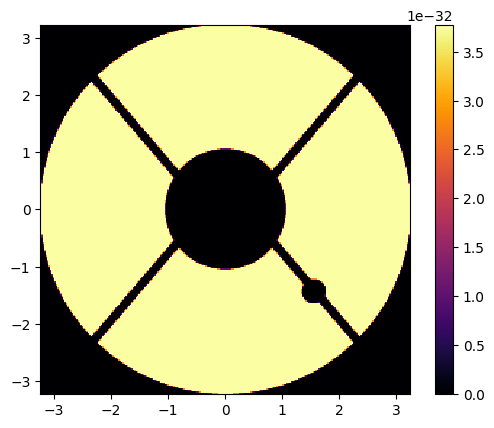

In [21]:
# Propagate light through Perfect CG from pupil plane to Lyot plane
wf = Wavefront(telescope_pupil, wavelength)
wf.total_power = 1 
lyot_plane = coro(wf)

imshow_field(lyot_plane.intensity, cmap='inferno')
plt.colorbar()
plt.show()


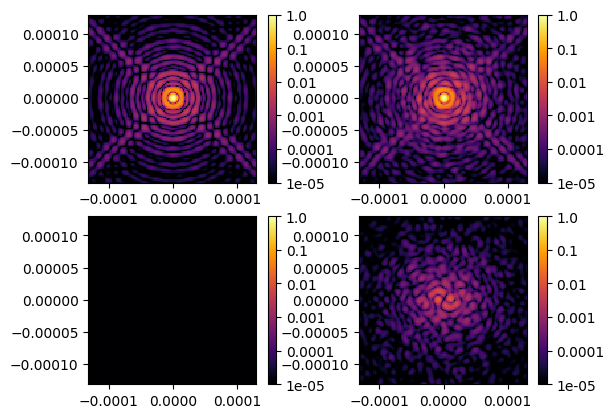

In [35]:
# deformable_mirror.random(0.2 * wavelength)


psf = prop(wf).power # prop = lense
aberrated_psf = prop(sa(wf)).power # prop = lense
norm = psf.max()

corim = prop(coro(wf)).power # prop = lense
aberrated_corim = prop(coro(sa(wf))).power # prop = lense

plt.subplot(2,2,1)
imshow_psf(psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,2)
imshow_psf(aberrated_psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,3)
imshow_psf(corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,4)
imshow_psf(aberrated_corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.show()

/tmp/ipykernel_58937/3554996406.py:5: RuntimeWarning: divide by zero encountered in log10
  imshow_field(np.log10(img / focal_image.intensity.max()), vmin=-5, vmax=0, cmap='inferno')


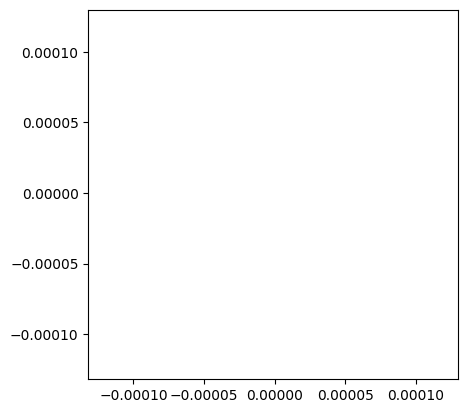

In [279]:
# Look at off-axis object to see star again
wf = Wavefront(telescope_pupil * np.exp(2j * np.pi * pupil_grid.x * 1.5))
img = prop(lyot_stop(coro(wf))).intensity

imshow_field(np.log10(img / focal_image.intensity.max()), vmin=-5, vmax=0, cmap='inferno')
plt.show()

In [36]:
# Fourier at 5 lambda/D
# cosine:  np.cos(2 * np.pi * 5 * pupil_grid.x / Dtel)

In [ ]:
# # Jacobian (iEFC)

# response_matrix = [] # Initialize empty vector of slopes

# probe_amp = 0.01 * wavelength # Set a probe amplitude
# calibration_amp = 0.01 * wavelength
# # probe_amp2 = 0.01 * wavelength # Set a probe amplitude


# wf = Wavefront(telescope_pupil, wavelength) # Reference WF
# wf.total_power = 1

# norm = prop(wf).power.max() # Normalize w/ unaberrated WF

# num_modes = deformable_mirror.num_actuators # TODO: Need to constrain number of modes to just the control region? 

# #Change num_modes for debugging 
# num_modes = 5

# amps = np.ones(num_modes) * probe_amp
# # amps2 = np.ones(num_modes) * probe_amp2

# deformable_mirror.flatten()

# for ind in range(num_modes):
#     if ind % 10 == 0:
#         print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
    
#     calibration_images = []
#     for cal_amp in [-calibration_amp, calibration_amp]:

#         # Add the mode that we are calibrating
#         deformable_mirror.actuators[ind] += cal_amp

#         difference_images = []
#         for probe_pattern in [400, 401]:    # Select actuators 400 and 401 to probe
#             # Apply +/- probe 1
#             probed_psfs = []
#             for amp in [-probe_amp, probe_amp]:
#                 deformable_mirror.actuators[probe_pattern] += amp   # Apply a probe on DM

#                 # Propagate WF through system
#                 dm_wf = deformable_mirror.forward(wf) # WF after DM
#                 lyot_wf = coro(dm_wf) # WF in the Lyot Plane
#                 psf = prop(lyot_wf).power
#                 probed_psfs.append(psf)

#                 deformable_mirror.actuators[probe_pattern] -= amp
#                 # plt.figure()
#                 # imshow_psf(psf / norm, vmin=1e-8, vmax=1e-2)
#                 # Compute difference image 1
#             diff_image = probed_psfs[1] - probed_psfs[0]
#             # print(diff_image)
#             difference_images.append(diff_image)
    
#             pwp_measurement = np.concatenate((difference_images[0], difference_images[1]))
#         calibration_images.append(pwp_measurement)

#         # Remove the mode that we are calibrating
#         deformable_mirror.actuators[ind] -= calibration_amp


#     slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

#     response_matrix.append(slope) # Append slope vector to response matrix

#     plt.subplot(1,2,1)
#     imshow_field(difference_images[0])

#     plt.subplot(1,2,2)
#     imshow_field(difference_images[1])
#     plt.show()

#     #deformable_mirror.actuators[ind-1] = amp*probe_amp # Apply +/- probe 2

#     # Propagate WF through system
#     #dm_wf = deformable_mirror.forward(wf) # WF after DM
#     #lyot_wf = coro(dm_wf) # WF in the Lyot Plane
#     #psf = prop(lyot_wf).power

#     # Compute difference image
#     #diff_image2 = psf[1] - psf[0]

#     #pwp_signal = [diff_image1, diff_image2] # Obtain pairwise probing signal

#     #slope =  probe_amp*((pwp_signal[0] - pwp_signal[1])/(2*amp)) # Construct slope vector

#     #response_matrix.append(slope) # Append slope vector to response matrix


# #################################### JACOBIAN PSEUDOCODE IEFC ##################################################

# # Initialize empty vector of slopes (response matrix)
# # For each mode
# #   For amplitude in [-amp, amp]
#     #   Apply mode on DM w/ a given amplitude

#     #   Apply + probe 1
#     #   Propagate WF through system
#     #   Take intensity image (PSF)
#     #   Apply - probe 1
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Compute difference image 1

#     #   Apply + probe 2
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Apply - probe 2
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Compute difference image 2

#     #   Pair-wise probing sensing signal = [diff 1, diff_2]
#     #   Concatenate intensity differences
#     #   Construct slope vector -- amplitude * [(diff 1 - diff 2)/(2*amp)]
# #   Append slope vector to response matrix

    





In [ ]:

for fx in fxs:
    for fy in fys:
        np.cos(2 * np.pi * fx * pupil_grid.x / Dtel + 2 * np.pi * fy * pupil_grid.y / Dtel)